In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

script_dir = os.path.abspath("")
mymodule_dir = os.path.join(script_dir, "..", "scripts")
sys.path.append(mymodule_dir)
import cleaning 

pd.set_option("mode.copy_on_write", True)
sns.set_theme()
sns.set_style("white")
%config InlineBackend.figure_format = "retina"

jobs = cleaning.prep(pd.read_pickle("../data/jobs.pkl"))

# jobs.head()

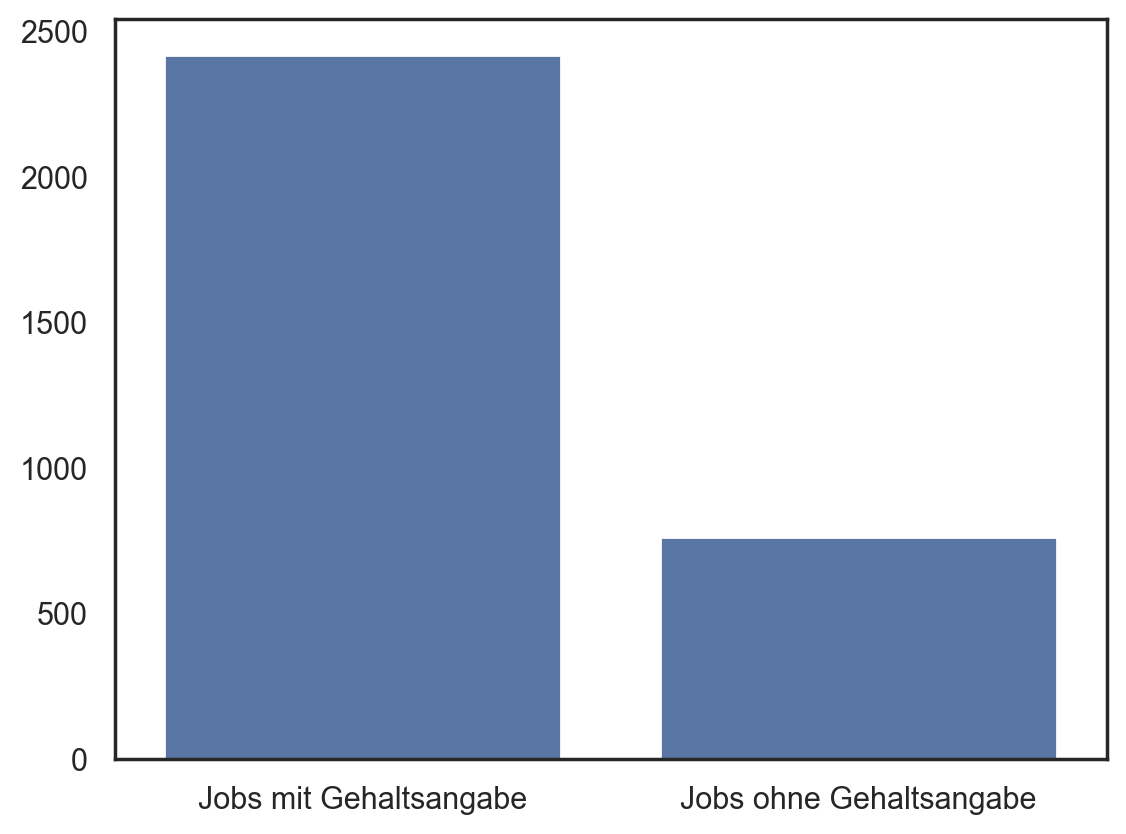

In [2]:
jobs_ohne_gehalt = jobs[jobs["Gehalt_min"].isna()]
jobs_mit_gehalt = jobs[jobs["Gehalt_min"].notna()]

g = sns.barplot(
    y=[len(jobs_mit_gehalt), len(jobs_ohne_gehalt)],
    x=["Jobs mit Gehaltsangabe", "Jobs ohne Gehaltsangabe"],
)
plt.show()

# Min / Max Gehalt

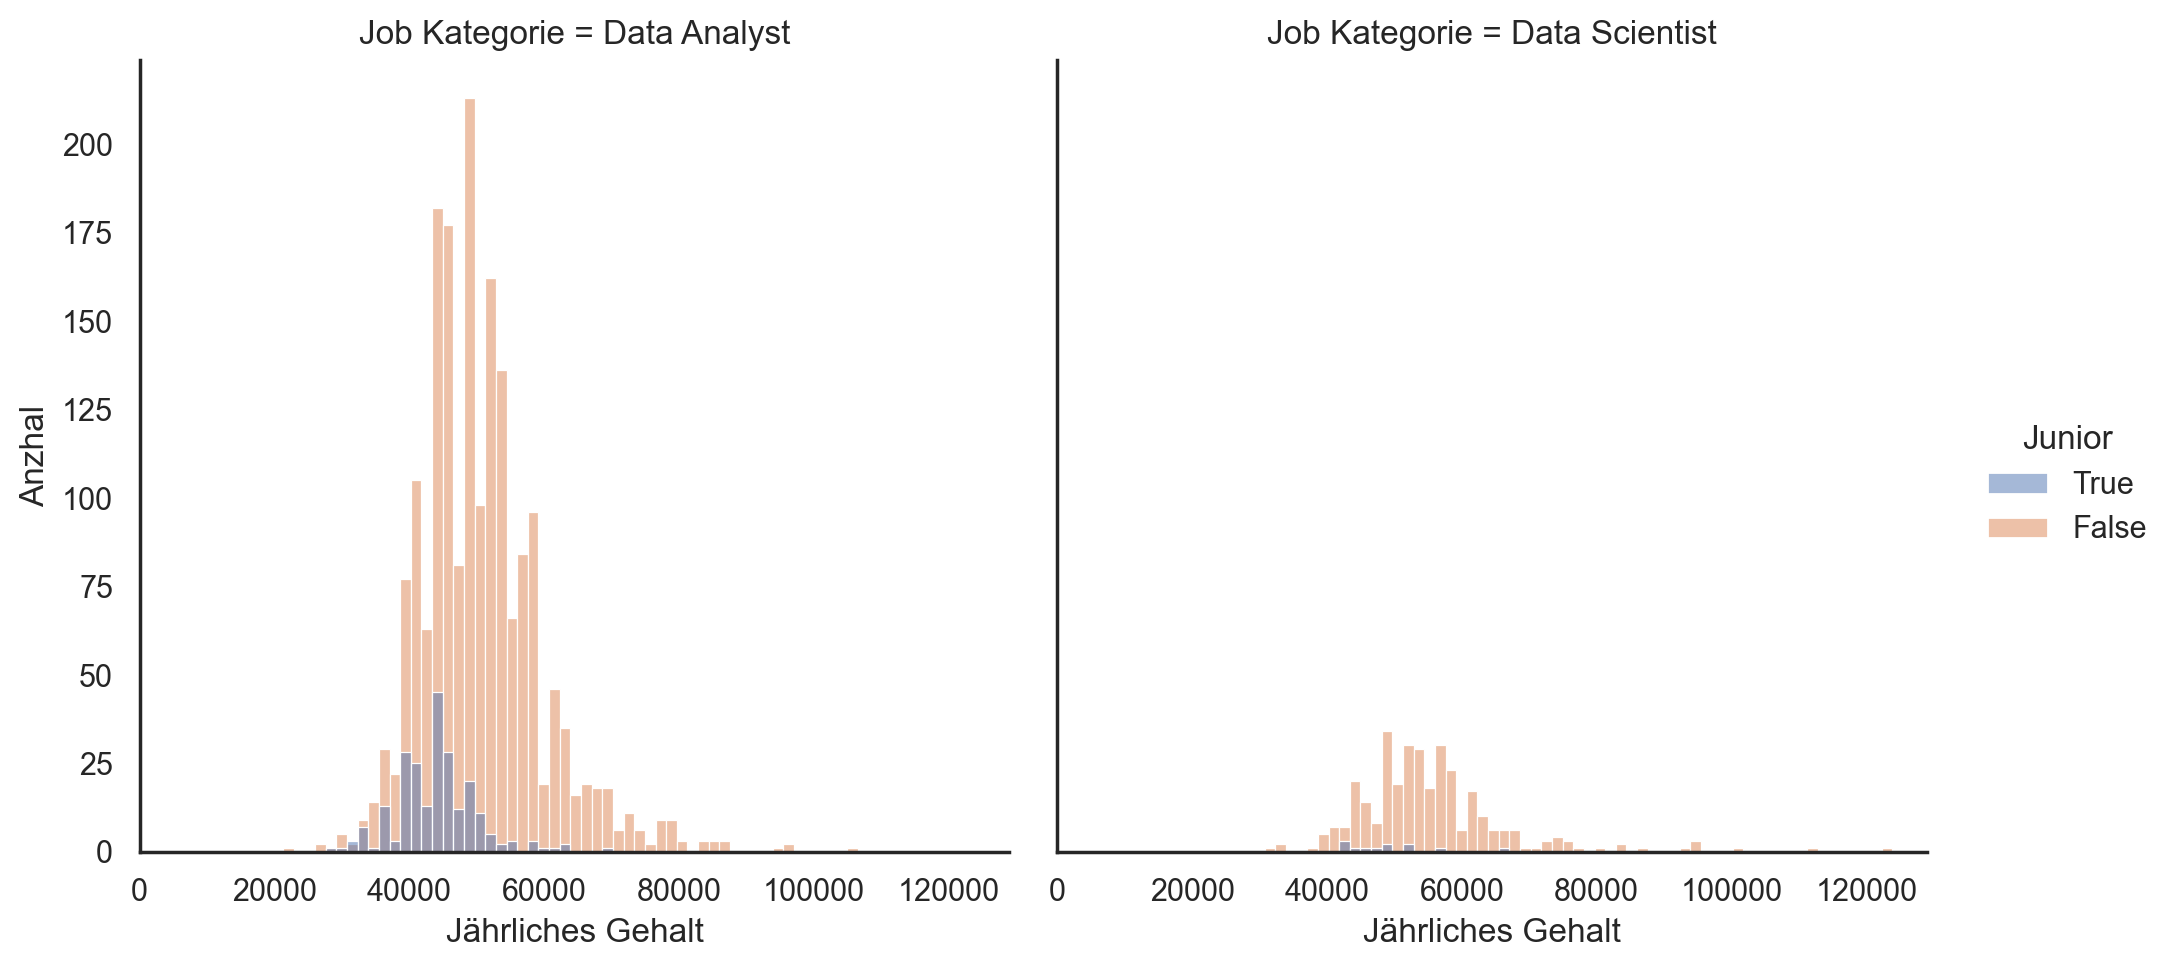

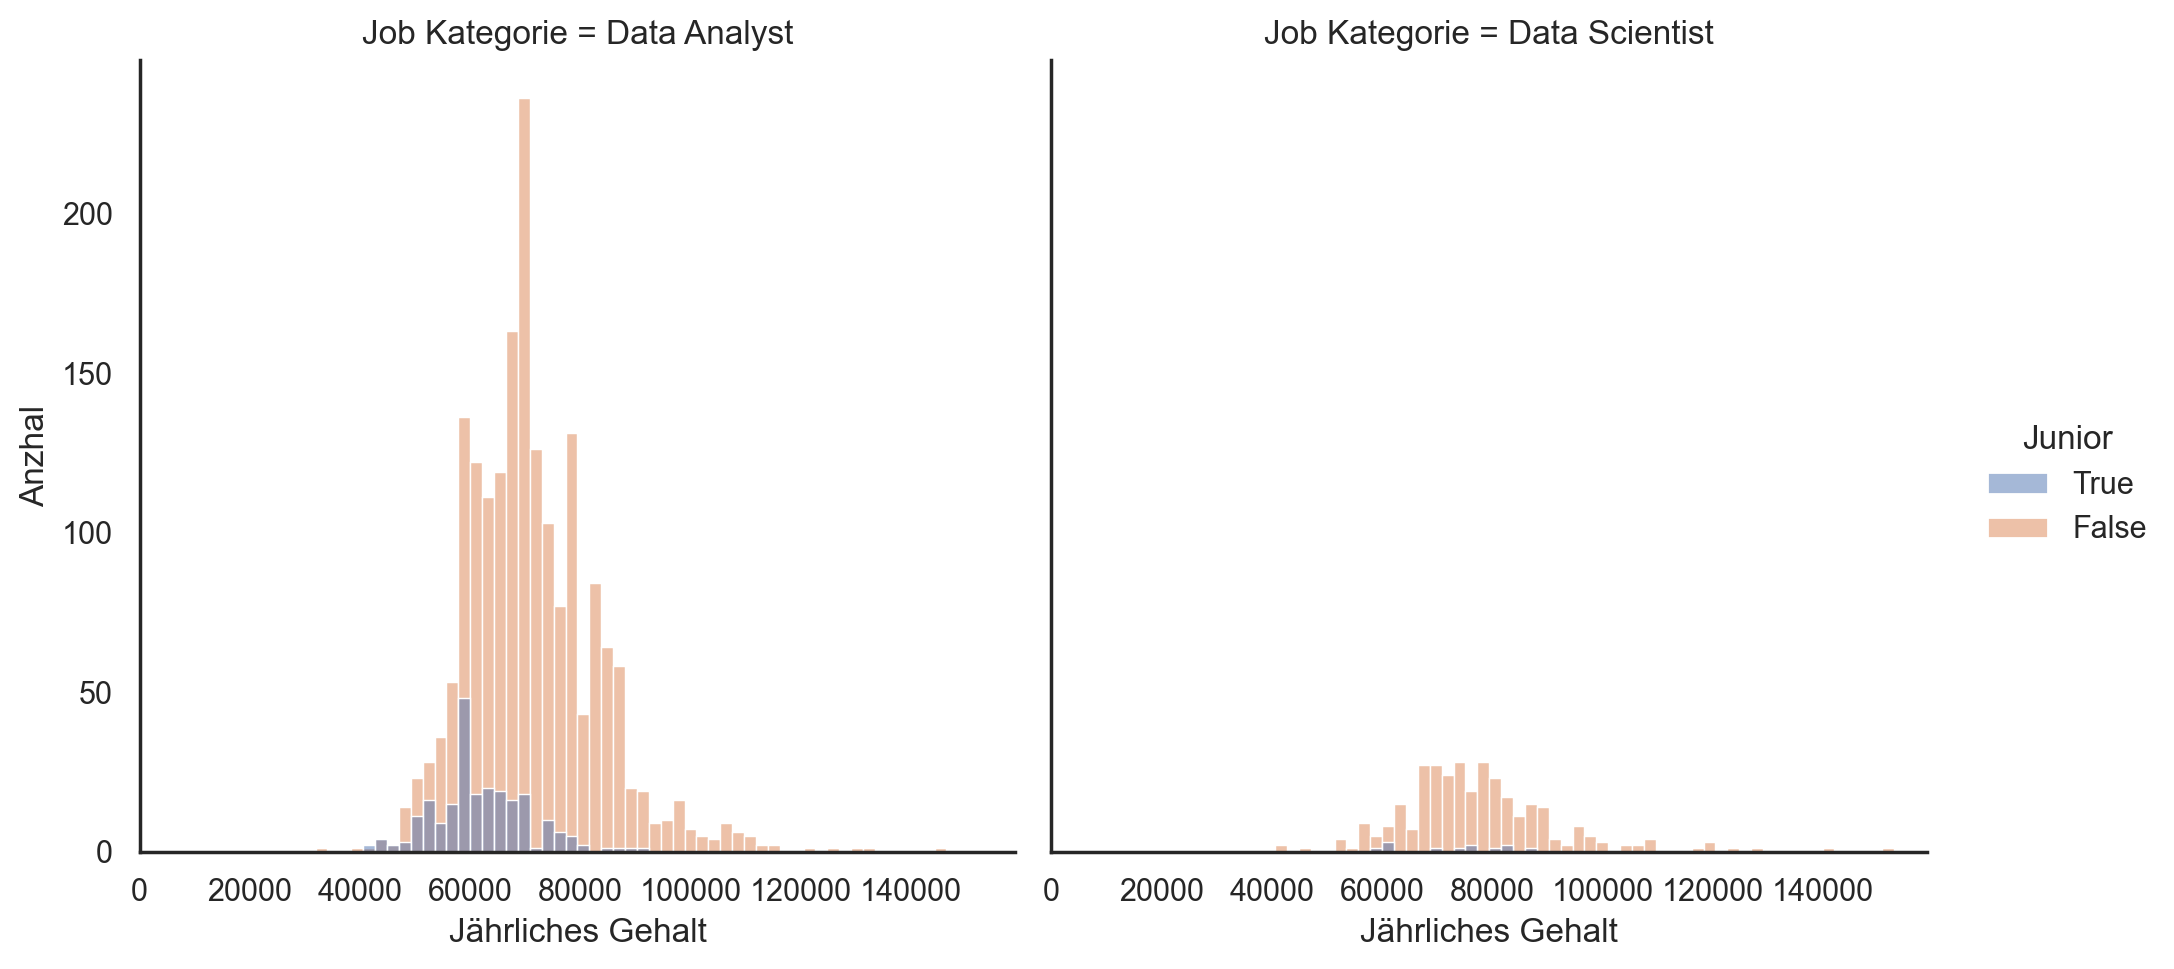

In [3]:
for gehalt in ["Gehalt_min_yearly", "Gehalt_max_yearly"]:
    g = sns.displot(
        data=jobs,
        x=gehalt,
        col="Job Kategorie",
        hue="Junior",
        hue_order=[True, False],
        kind="hist",
    )
    # g.refline(x=55_000)
    g.set(xlabel="Jährliches Gehalt", ylabel="Anzhal", xlim=(0, None))
plt.show()

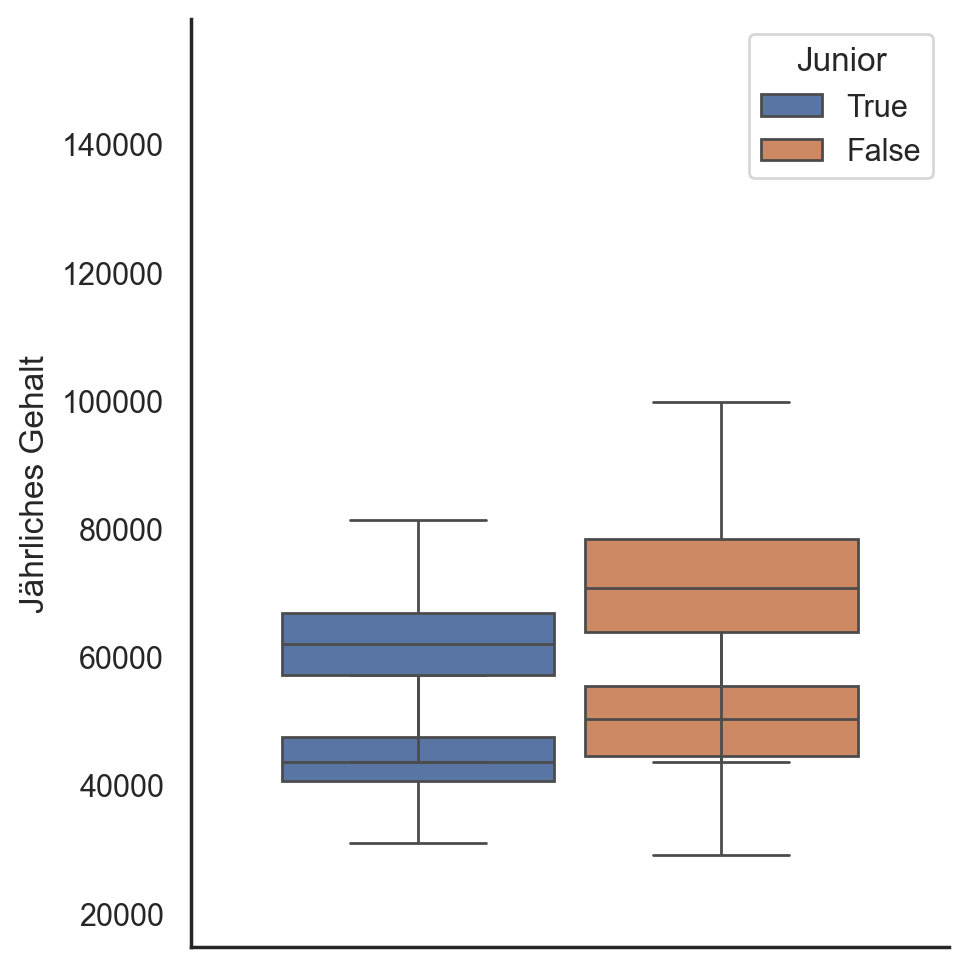

In [4]:
g = sns.catplot(
    data=jobs,
    y="Gehalt_min_yearly",
    hue="Junior",
    hue_order=[True, False],
    kind="box",
    gap=0.1,
    fliersize=0,
    legend=False,
)
h = sns.boxplot(
    data=jobs,
    y="Gehalt_max_yearly",
    hue="Junior",
    hue_order=[True, False],
    gap=0.1,
    fliersize=0,
)
g.set(ylabel="Jährliches Gehalt")
# g.refline(y=55_000)

# g = sns.catplot(data=jobs, x="Gehalt_max_yearly", col="Job Kategorie", hue="Junior", kind="box")

plt.show()

# Durchschnittsgehalt

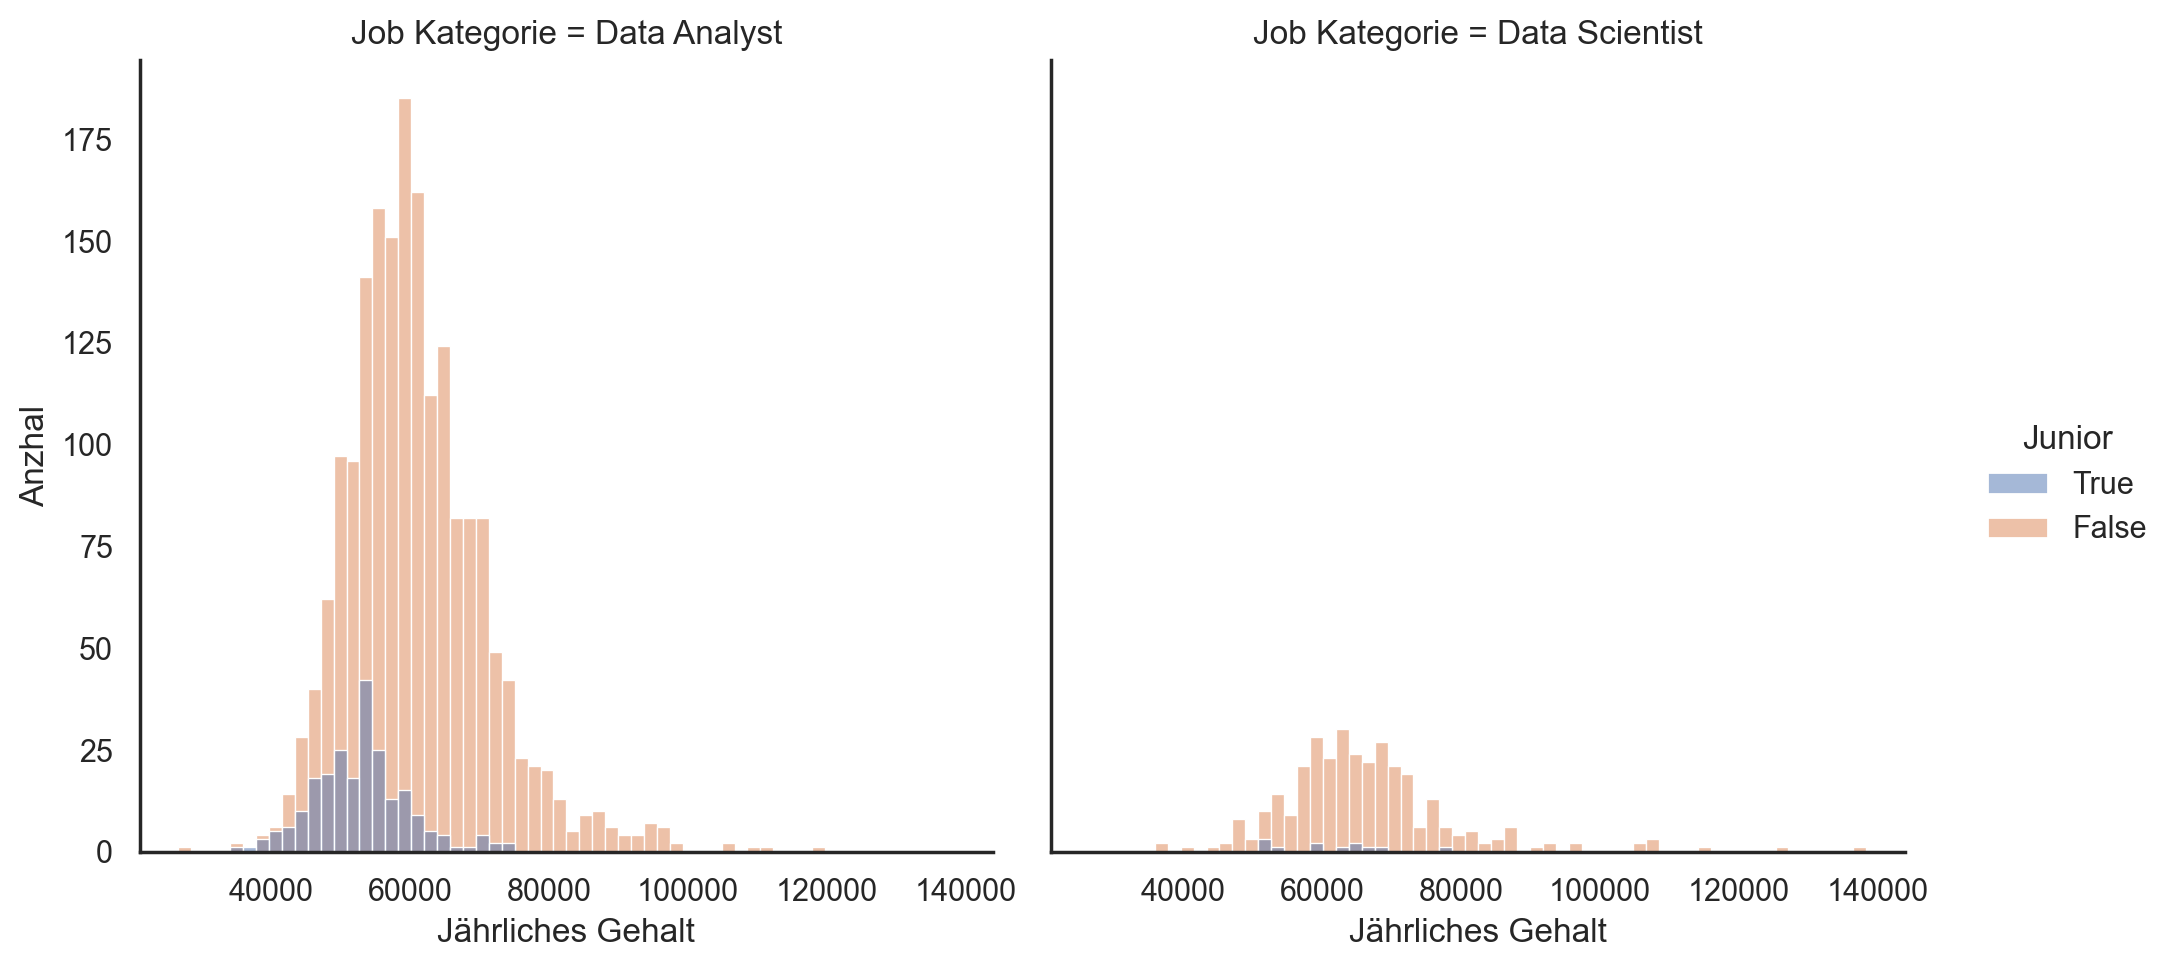

In [5]:
g = sns.displot(
    data=jobs,
    x="Gehalt_durchschnitt_yearly",
    col="Job Kategorie",
    hue="Junior",
    hue_order=[True, False],
    kind="hist",
)
# g.refline(x=55_000)
g.set(xlabel="Jährliches Gehalt", ylabel="Anzhal")

plt.show()

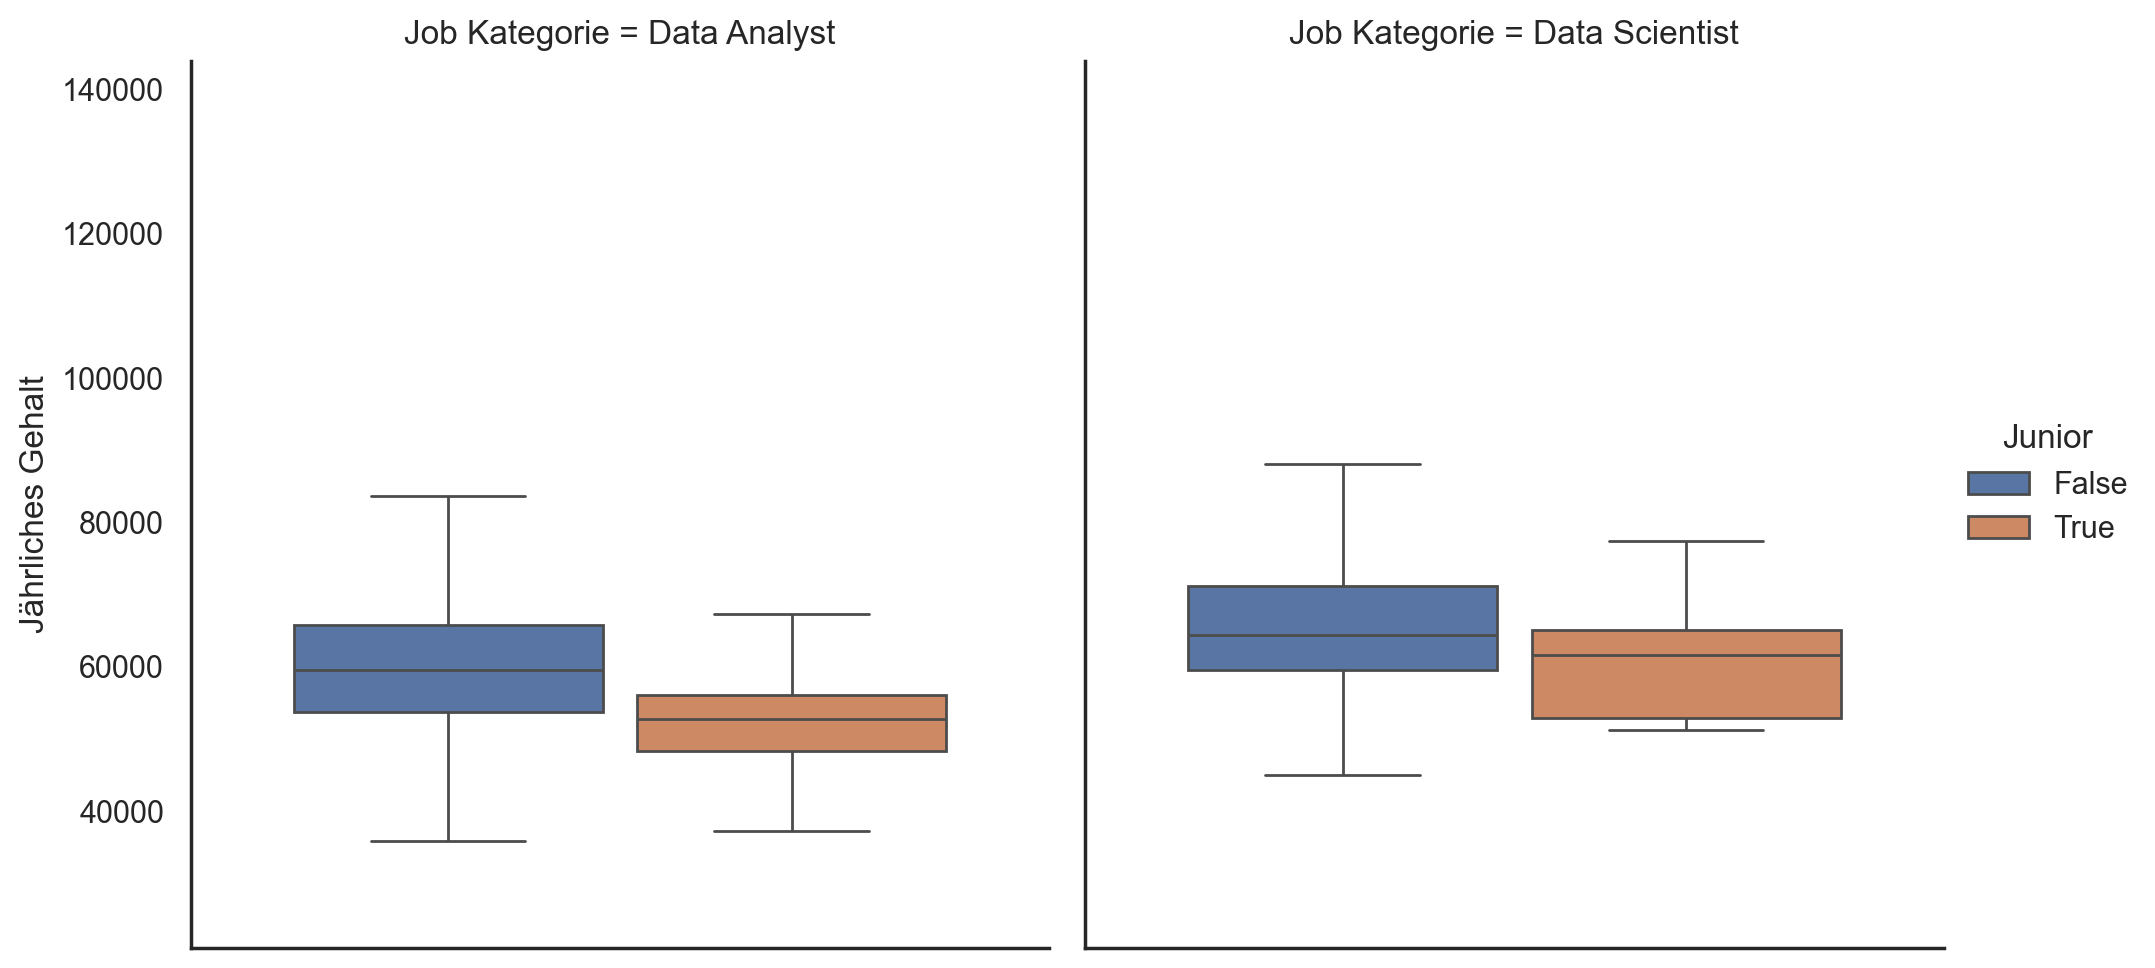

In [6]:
g = sns.catplot(
    data=jobs,
    y="Gehalt_durchschnitt_yearly",
    col="Job Kategorie",
    hue="Junior",
    kind="box",
    gap=0.1,
    fliersize=0,
)
g.set(ylabel="Jährliches Gehalt")
plt.show()

# Clustering

In [7]:
jobs_input = jobs_mit_gehalt.loc[
    :,
    ["Gehalt_min_yearly", "Gehalt_max_yearly"],
]

In [8]:
jobs_input["Gehalt_min_yearly"] = jobs_input["Gehalt_min_yearly"] // 5_000 * 5_000
jobs_input["Gehalt_max_yearly"] = jobs_input["Gehalt_max_yearly"] // 5_000 * 5_000

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[Errno 2] No such file or directory: 'sysctl'
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py", line 270, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexe

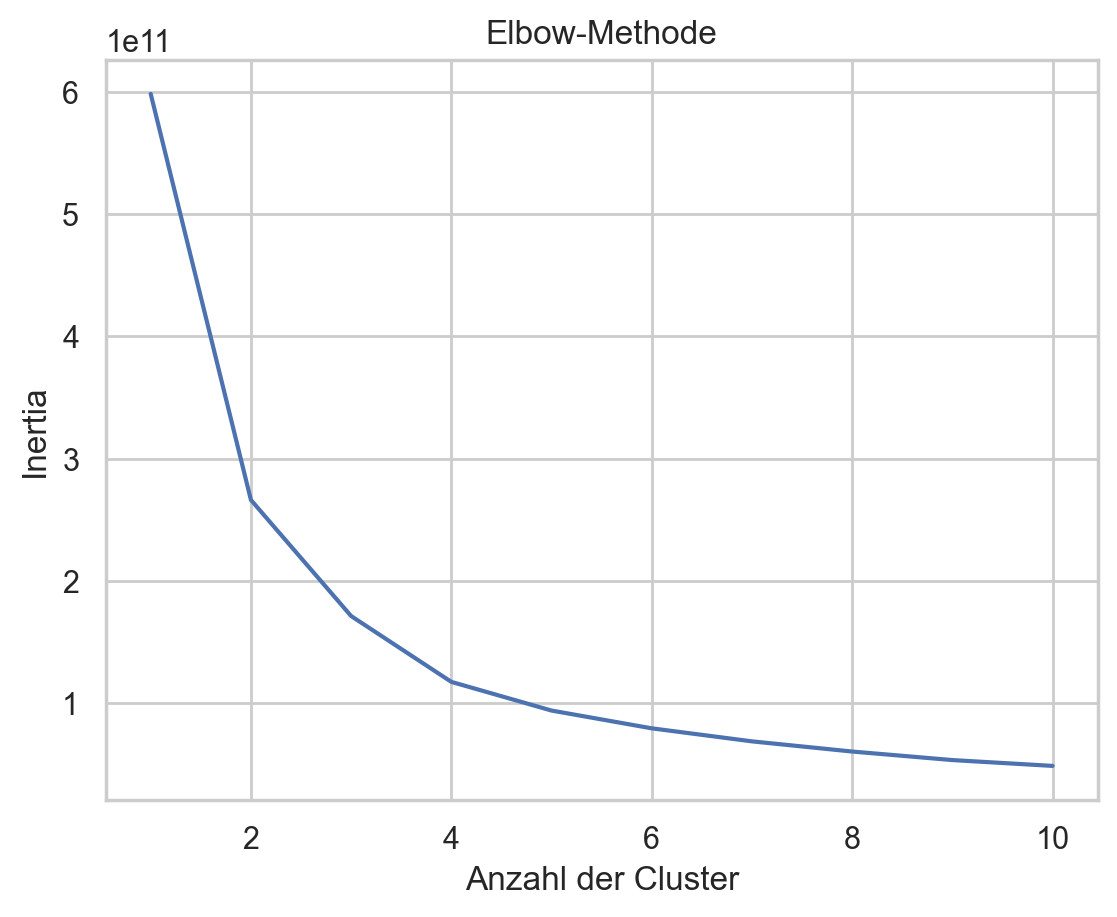

In [9]:
from sklearn.cluster import KMeans

sns.set_style("whitegrid")

inertia = []

for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, n_init=100, random_state=0)
    kmeans.fit_predict(jobs_input)
    inertia.append(kmeans.inertia_)


plt.plot(range(1, 11), inertia)
plt.title("Elbow-Methode")
plt.xlabel("Anzahl der Cluster")
plt.ylabel("Inertia")
plt.show()

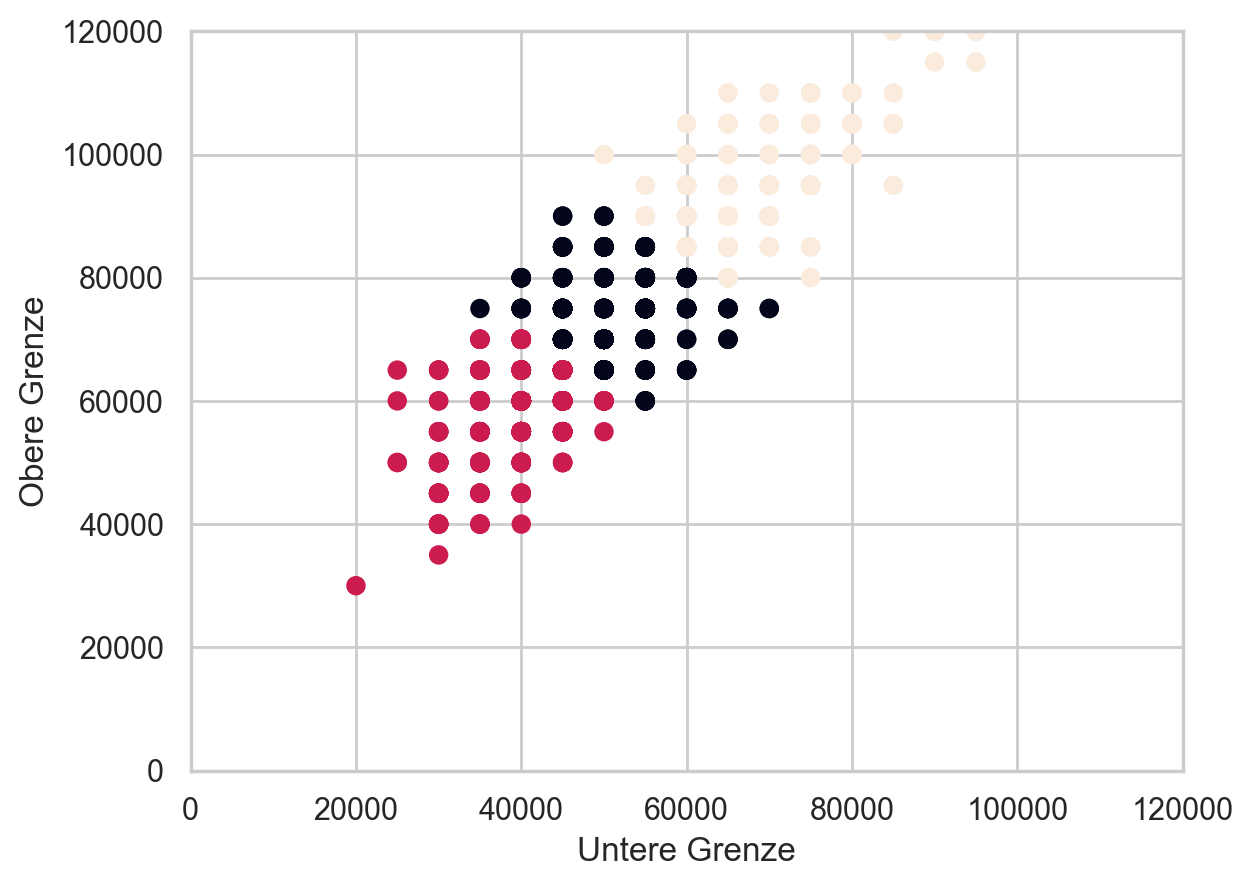

In [10]:
kmeans = KMeans(n_clusters=3, n_init=100, random_state=0)
kmeans.fit_predict(jobs_input)
plt.scatter(jobs_input.iloc[:, 0], jobs_input.iloc[:, 1], c=kmeans.labels_)
plt.xlabel("Untere Grenze")
plt.ylabel("Obere Grenze")
plt.ylim(ymin=0, ymax=120_000)
plt.xlim(xmin=0, xmax=120_000)

plt.show()